In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.feature import hog
import glob
import os
import sklearn
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import itertools
from sklearn import grid_search
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
from cv2 import HOGDescriptor
import seaborn as sns

C:\Users\keshav_aggarwal\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\keshav_aggarwal\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
vehiclesDir = os.listdir('vehicles')
imagesVehiclePath = []
for folder in vehiclesDir:
    path = os.path.join(os.path.join('vehicles',folder), '*.png')
    imagesVehiclePath.append(glob.glob(path))
    
nonVehiclesDir = os.listdir('non-vehicles')
nonImagesVehiclePath = []
for folder in nonVehiclesDir:
    path = os.path.join(os.path.join('non-vehicles',folder), '*.png')
    nonImagesVehiclePath.append(glob.glob(path))

In [3]:
vehicle = []
nonVehicle = []
for imgDirPath in imagesVehiclePath:
    for imgPath in imgDirPath:
        img = cv2.cvtColor(cv2.imread(imgPath), cv2.COLOR_BGR2RGB)
        vehicle.append(img)
        vehicle.append(cv2.flip(img,1))

for imgDirPath in nonImagesVehiclePath:
    for imgPath in imgDirPath:
        img = cv2.cvtColor(cv2.imread(imgPath), cv2.COLOR_BGR2RGB)
        nonVehicle.append(img)
        nonVehicle.append(cv2.flip(img,1))
        nonVehicle.append(cv2.flip(img,0))


In [4]:
print("Number of Vehicle Data samples ", len(vehicle))
print("Number of Non-Vehicle Data samples ", len(nonVehicle))

Number of Vehicle Data samples  17562
Number of Non-Vehicle Data samples  26904


In [5]:
y_label_class = [1,0]
y_label_vehicle = [y_label_class[0]]*len(vehicle)
y_label_nonVehicle = [y_label_class[1]]*len(nonVehicle)

data = np.vstack([vehicle, nonVehicle])
label = np.hstack([y_label_vehicle, y_label_nonVehicle])

#### Generate Features

In [7]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    fhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range) #First channel histogram
    shist = np.histogram(img[:,:,1], bins=nbins, range=bins_range) # Second channel histogram
    thist = np.histogram(img[:,:,2], bins=nbins, range=bins_range) # Third channel histogram
    # Generating bin centers
    bin_edges = fhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((fhist[0], shist[0], thist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features, fhist, shist, thist, bin_centers

def bin_spatial_features(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
     if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
     else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

#Training using color and HOG features
#Selected color features - cspace = 'RGB' and spatial_size = 16,16

def extract_features(imgs, color_space='RGB', spatial_size=(16, 16),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img in imgs:
        file_features = []
        # Read in each one by one
        image = img
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #convert to RGB color space
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial_features(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist_features(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

#### Training Classifier

In [113]:
%%time
# Train classifier using HOG and color features

from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import time
from sklearn.cross_validation import train_test_split


color_space = 'YCrCb' 
orient = 11  
pix_per_cell = 16 
cell_per_block = 1 
hog_channel = 'ALL' 
spatial_size = (16, 16)
hist_bins = 16    
spatial_feat = False
hist_feat = False 
hog_feat = True 
y_start_stop = [300, None]

car_features = extract_features(vehicle, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(nonVehicle, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC

svc.fit(X_train, y_train)

print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

#Tried YCrCb, 8, 1 _ good performance 
#Tried YCrCb, 8, 2 _ good performance but very slow


Using: 11 orientations 16 pixels per cell and 1 cells per block
Feature vector length: 528
0.09 Seconds to train SVC...
Test Accuracy of SVC =  0.987
My SVC predicts:  [ 0.  1.  1.  1.  1.  1.  1.  1.  0.  1.]
For these 10 labels:  [ 0.  1.  1.  1.  1.  1.  1.  1.  0.  1.]
0.0625 Seconds to predict 10 labels with SVC
Wall time: 8min 45s


Confusion Matrix

Confusion matrix


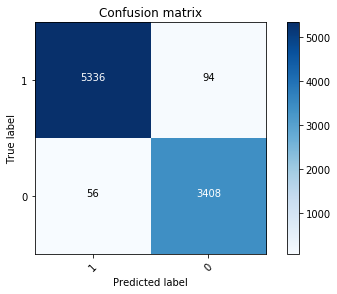

In [104]:
def plot_confusion_matrix(cm, classes,title='Confusion matrix',cmap=plt.cm.Blues):
    print('Confusion matrix')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
y_pred = svc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, y_label_class)


### Checking the car in an image

In [105]:
#Define functions to extract features from test images

def single_img_features(img, color_space='HSV', spatial_size=(16, 16), 
                        hist_bins=16, orient=6, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=2,
                        spatial_feat=False, hist_feat=False, hog_feat=True): 
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial_features(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist_features(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=False, hog_feat=False):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [106]:
##Sliding window implementation
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

693
250
259
34
Windows Final 1236


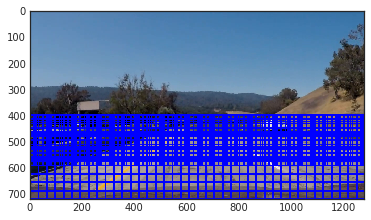

In [107]:
image = cv2.imread('Input345.jpg')
#image = cv2.imread('test_images/test1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

xy_window = [(64,64), (96,96), (128,128)]
y_start_stop = [[400, 600], [400, 600], [400, None]]

windows_temp = []
for i in range(len(xy_window)):
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop[i], 
                        xy_window=xy_window[i], xy_overlap=(0.75, 0.75))
    print(len(windows))
    windows_temp.append(windows) 

#Flatten windows_temp
windows_final = sum(windows_temp, [])

print("Windows Final",len(windows_final))
window_img = draw_boxes(image, windows_final, color=(0, 0, 255), thick=6)   
with sns.axes_style("white"):
    plt.imshow(window_img)

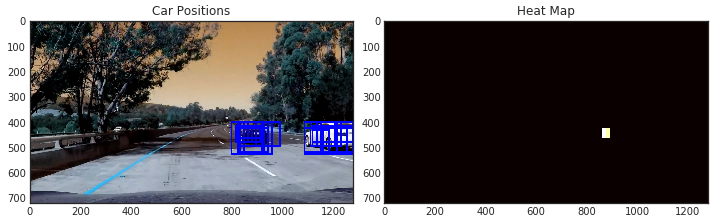

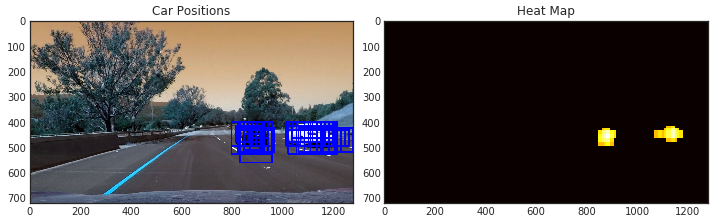

In [108]:
from scipy.ndimage.measurements import label
files = ['test5.jpg','test6.jpg']
for file in files:
    image = cv2.imread(file)
    draw_image = np.copy(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    #image = image.astype(np.float32)/255

#     xy_window = [(96,96),(128,128)]
#     y_start_stop = [[350, 600], [350, None]]

    xy_window = [(64,64), (96,96), (128,128), (256,256)]
    y_start_stop = [[400, 600], [400, 600], [400, None], [400, None]]
    windows_temp = []
    for i in range(len(xy_window)):
        windows = slide_window(image, x_start_stop=[700, None], y_start_stop=y_start_stop[i], 
                            xy_window=xy_window[i], xy_overlap=(0.75, 0.75))
        #print(len(windows))
        windows_temp.append(windows) 

    #Flatten windows_temp
    windows_final = sum(windows_temp, [])
    color_space = 'YCrCb'#Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11  # HOG orientations
    pix_per_cell = 16 # HOG pixels per cell
    cell_per_block = 1 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = False # Spatial features on or off
    hist_feat = False # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [300, None] # Min and max in y to search in slide_window()

    hot_windows = search_windows(image, windows_final, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)     
    
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,10)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    with sns.axes_style("white"):
        fig = plt.figure(figsize=(10, 10))
        plt.subplot(121)
        plt.imshow(window_img)
        plt.title('Car Positions')
        plt.subplot(122)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        fig.tight_layout()

In [109]:
def hot_windows(input_image, windows, classifier, scaler, draw=True):
    #global hot_windows_list
    #xy_window = [(96,96), (128,128), (256,256)]
    #y_start_stop = [[400, 650], [400, None], [400, None]]

    xy_window = [ (64,64), (96,96), (128,96)]
    y_start_stop = [[400, 600], [400, 600], [400, None]]

    windows_temp = []
    for i in range(len(xy_window)):
        windows = slide_window(image, x_start_stop=[700, None], y_start_stop=y_start_stop[i], 
                            xy_window=xy_window[i], xy_overlap=(0.6, 0.6))
        #print(len(windows))
        windows_temp.append(windows) 

    #Flatten windows_temp
    windows_final = sum(windows_temp, [])
    
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11  # HOG orientations
    pix_per_cell = 16 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = False # Spatial features on or off
    hist_feat = False # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [300, None] # Min and max in y to search in slide_window()


    hot_windows = search_windows(input_image, windows_final, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
   
    #hot_windows_list.append(hot_windows)
    #print("Hot windows: ", hot_windows)
    if draw == True:
        draw_image = np.copy(input_image)
        window_img = draw_boxes(input_image, hot_windows, color=(0, 0, 255), thick=6)
        return window_img
    
    return hot_windows

In [110]:
def process_image(image, n_frames=15, threshold=20):  
     
    hot_windows_temp =[]
    global hot_windows_list
    global windows
    global hot_windows_final
   
    windows = hot_windows(image, windows, svc, X_scaler, draw=False)
    hot_windows_list.append(windows)
   
    if len(hot_windows_list) <= n_frames:
         hot_windows_final = sum(hot_windows_list, []) # Add windows from all available frames
    
    #Look at last n frames and append all hot windows found
    else: 
        for val in hot_windows_list[(len(hot_windows_list) - n_frames -1) : (len(hot_windows_list)-1)]:
            hot_windows_temp.append(val)
    #Flatten this list
        hot_windows_final = sum(hot_windows_temp, [])
    
    #draw_image = np.copy(image)
    #window_img = draw_boxes(draw_image, hot_windows_final, color=(0, 0, 255), thick=6)   
    
    #Create a frame_heatmap
    frame_heatmap = np.zeros_like(image[:,:,0])
    
    frame_heatmap = add_heat(frame_heatmap, hot_windows_final)
    
    # Apply threshold
    frame_heatmap = apply_threshold(frame_heatmap, threshold)
    
    labels = label(frame_heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    plt.imshow(draw_img)
    return draw_img

In [111]:
i = 0
hot_windows_list = []
import moviepy
from moviepy.editor import VideoFileClip
video_output1 = 'output22.mp4'
video_input2 = VideoFileClip('project_video.mp4').subclip(18, 20)
processed_video = video_input2.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)
video_input2.reader.close()
video_input2.audio.reader.close_proc()

ValueError: operands could not be broadcast together with shapes (1,1188) (528,) (1,1188) 